<a href="https://colab.research.google.com/github/deadwalker10s/-ideal-inventions/blob/main/handgesture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/AssemblyAI-Examples/mediapipe-python.git
!pip install mediapipe
!pip install PyQt5
!pip install ipython==7.34.0

Cloning into 'mediapipe-python'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 45 (delta 14), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (45/45), 31.45 MiB | 20.67 MiB/s, done.
Resolving deltas: 100% (14/14), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.5 MB/s eta 0:00:00


In [2]:
import cv2
import mediapipe as mp
import urllib.request
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
import PyQt5
from PIL import Image
from IPython.display import HTML
import importlib
from base64 import b64encode

nb_helpers = importlib.import_module("mediapipe-python.nb_helpers")

In [3]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic
mp_pose = mp.solutions.pose
mp_face_mesh = mp.solutions.face_mesh

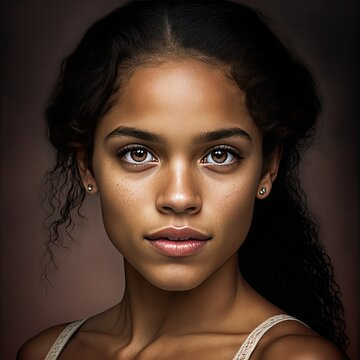

In [7]:
face_url = "https://t3.ftcdn.net/jpg/05/61/43/26/360_F_561432620_ghqin7jE48RP4B6JrOpCpio536LOeTVC.jpg"
urllib.request.urlretrieve(face_url, "face_image.jpg")

img = Image.open('face_image.jpg')
display(img)

In [8]:
file = 'face_image.jpg'
drawing_spec = mp_drawing.DrawingSpec(thickness=2, circle_radius=1, color=[4, 244, 4])

# Create a face mesh object
with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:

    # Read image file with cv2 and convert from BGR to RGB
    image = cv2.imread(file)
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

face_found = bool(results.multi_face_landmarks)

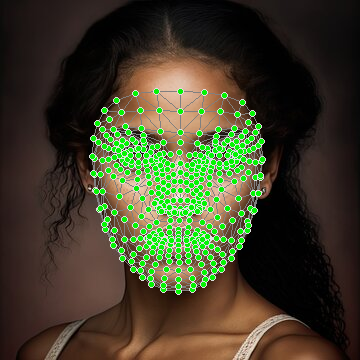

In [9]:
if face_found:
    # Create a copy of the image
    annotated_image = image.copy()

    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=results.multi_face_landmarks[0],
        connections=mp_face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=drawing_spec,
        connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())

    cv2.imwrite('face_tesselation_only.png', annotated_image)

img = Image.open('face_tesselation_only.png')
display(img)

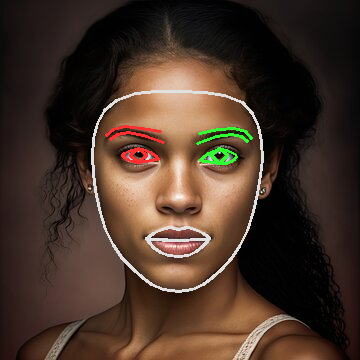

In [10]:
if face_found:
    # Create a copy of the image
    annotated_image = image.copy()
    for face_landmarks in results.multi_face_landmarks:

        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
                .get_default_face_mesh_contours_style())

        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
                .get_default_face_mesh_iris_connections_style())

    cv2.imwrite('face_contours_and_irises.png', annotated_image)

img = Image.open('face_contours_and_irises.png')
display(img)

In [11]:
# Fetch image for analysis
img_url = "https://static.turbosquid.com/Preview/2015/11/10__11_56_36/anthonystanding23dmetry3dhuman01.jpg5e774d4d-9b9e-456d-9d7b-fc4d741cf940Large.jpg"
urllib.request.urlretrieve(img_url, "pose.jpg")

('pose.jpg', <http.client.HTTPMessage at 0x7855d94bd870>)

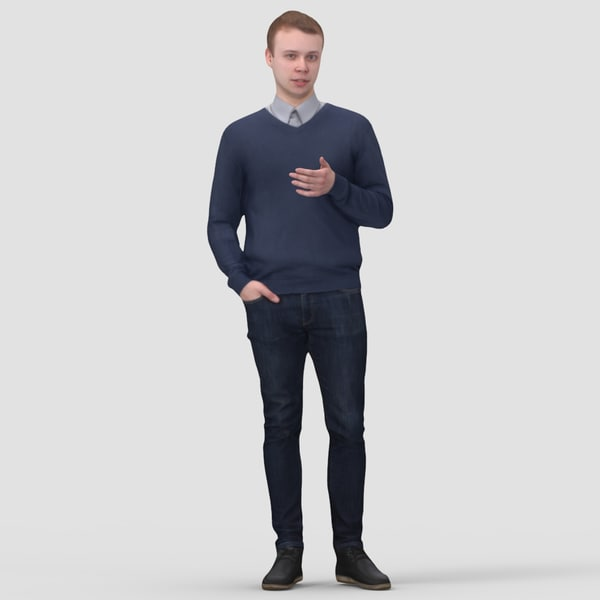

In [12]:
img = Image.open('pose.jpg')
display(img)

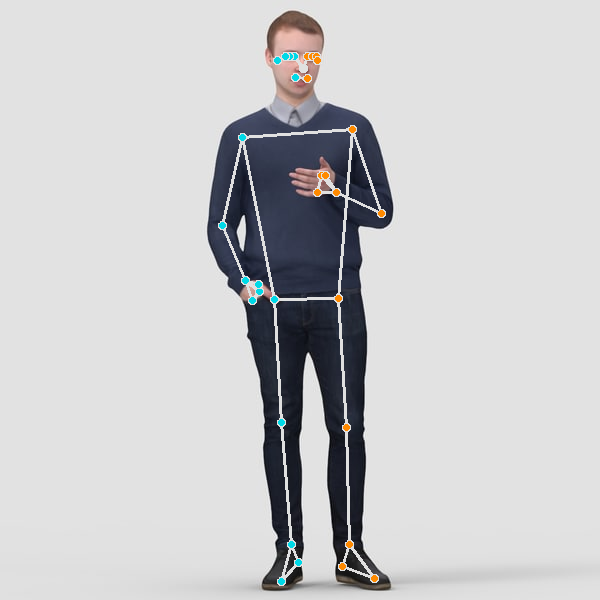

In [13]:
# Specify the image filename
file = 'pose.jpg'

# Create a MediaPipe `Pose` object
with mp_pose.Pose(static_image_mode=True,
                  model_complexity=2,
                  enable_segmentation=True) as pose:

    # Read the file in and get dims
    image = cv2.imread(file)

    # Convert the BGR image to RGB and then process with the `Pose` object.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Copy the iamge
annotated_image = image.copy()

# Draw pose, left and right hands, and face landmarks on the image with drawing specification defaults.
mp_drawing.draw_landmarks(annotated_image,
                          results.pose_landmarks,
                          mp_pose.POSE_CONNECTIONS,
                          landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

# Save image with drawing
filename = "pose_wireframe.png"
cv2.imwrite(filename, annotated_image)

# Open image
display(Image.open(filename))

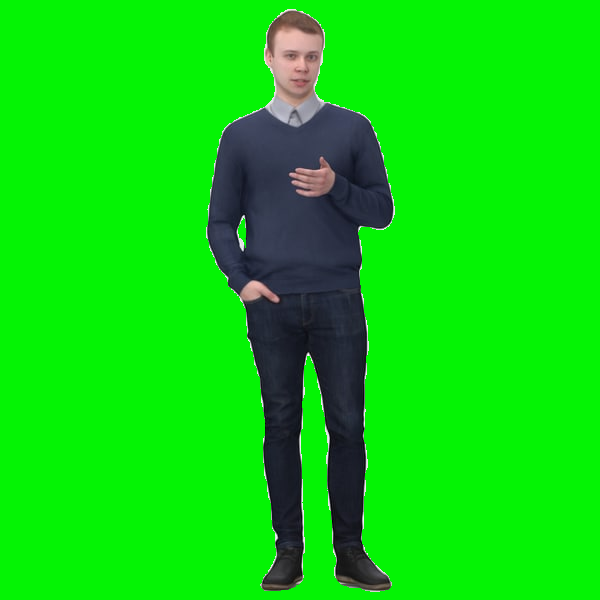

In [14]:
segmented_image = image.copy()

# Value in [0, 1] that says how "tight" to make the segmentation. Greater => tighter
tightness = .3

# Stacks the segmentation mask for 3 RGB channels, and then creates a filter for which pixels to keep
condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > tightness

# Creates a black background image
bg_image = np.zeros(image.shape, dtype=np.uint8)

# Can change the color by specifying (0-255) RGB values below
bg_image[:] = [4, 244, 4]

# Where the condition is met (i.e. above inclusion threshold), display annotated image
# Otherwise, use the background color
segmented_image = np.where(condition, segmented_image, bg_image)

filename = 'pose_green_screen.png'
cv2.imwrite(filename, segmented_image)
display(Image.open(filename))

In [15]:
poselandmarks_list = nb_helpers.poselandmarks_list

num = 0
for i in mp_holistic.POSE_CONNECTIONS:
    if num < 5:
        print(poselandmarks_list[i[0]], '-->', poselandmarks_list[i[1]])
    else:
        break
    num += 1

LEFT_WRIST --> LEFT_THUMB
RIGHT_WRIST --> RIGHT_INDEX
RIGHT_PINKY --> RIGHT_INDEX
LEFT_EYE_OUTER --> LEFT_EAR
RIGHT_ELBOW --> RIGHT_WRIST


In [16]:
# Pickle data as numpy array
data = np.empty((3, len(mp_holistic.PoseLandmark)))

landmarks = results.pose_world_landmarks.landmark
for i in range(len(mp_holistic.PoseLandmark)):
    data[:, i] = (landmarks[i].x, landmarks[i].y, landmarks[i].z)

In [17]:
#%matplotlib qt
%matplotlib inline

In [18]:
fig = plt.figure()
fig.set_size_inches(5, 5, True)
ax = fig.add_subplot(projection='3d')

nb_helpers.plot_data(data, ax)
nb_helpers.scale_axes(ax)

filename = 'pose_rotation.mp4'
nb_helpers.rotate_and_save(fig, ax, filename, save=True)

In [19]:
fig = plt.figure()
fig.set_size_inches(5, 5, True)
ax = fig.add_subplot(projection='3d')

nb_helpers.plot_data(data, ax)
nb_helpers.scale_axes(ax)

filename = 'pose_rotation.mp4'
nb_helpers.rotate_and_save(fig, ax, filename, save=True)

In [20]:
url = 'https://github.com/AssemblyAI-Examples/mediapipe-python/blob/main/walking.mp4?raw=true'
urllib.request.urlretrieve(url, 'walking.mp4')

('walking.mp4', <http.client.HTTPMessage at 0x7855d17334f0>)

In [21]:
file = 'walking.mp4'
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:

    cap = cv2.VideoCapture(file)

    if cap.isOpened() == False:
        print("Error opening video stream or file")
        raise TypeError

    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    data = np.zeros((3, len(mp_pose.PoseLandmark), length))


    frame_num = 0
    while cap.isOpened():
        ret, image = cap.read()
        if not ret:
            break

        image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
        results = pose.process(image)

        landmarks = results.pose_world_landmarks.landmark
        for i in range(len(mp_pose.PoseLandmark)):
            data[:, i, frame_num] = (landmarks[i].x, landmarks[i].y, landmarks[i].z)

        frame_num += 1

    cap.release()
    #out.release()

In [22]:
data.shape

(3, 33, 144)

In [23]:
fig = plt.figure()
fig.set_size_inches(5, 5, True)
ax = fig.add_subplot(projection='3d')

anim = nb_helpers.time_animate(data, fig, ax)

# Save
filename = "walking_wireframe.mp4"
anim.save(filename, fps=30, extra_args=['-vcodec', 'libx264'], dpi=300)

In [24]:
mp4 = open(filename,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls loop autoplay>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

https://colab.research.google.com/drive/1JrbV8PzQLrBZcxWYLDHvaClYHbmu6X52?usp=sharing&ref=assemblyai.com#scrollTo=5hoSVw-nfXE2